# Predire emozioni di una canzone

**Progetto di Programmazione di Applicazioni Data Intensive**   
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Studente Corrado Stortini   
`corrado.stortini2@studio.unibo.it`

## Setup

- Importo i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Introduzione

- L'obbiettivo è quello di classificare le canzoni in base a quale emozioni suscitano negli utenti che le ascoltano
    - 0 -> `Triste`
    - 1 -> `Felice`
    - 2 -> `Energetica`
    - 3 -> `Calma`
- Il dataset usato è `278k Emotion Labeled Spotify Songs`, reperibile su [_Kaggle_](https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset)
- Il dataset completo è composto da 12 variabili, di cui 1 di target (`label`)
- Sono presenti 278000 istanze, quindi ne prendo circa il 10%


In [7]:
url = "https://raw.githubusercontent.com/Corstor/DataIntensive_Progetto/main/278k_song_labelled.csv"
songs_tot = pd.read_csv(url, index_col="Unnamed: 0")

songs = songs_tot[:27800]
songs.head(10)

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1
5,166920.0,0.572,0.837,-7.876,0.0367,0.0197,0.000000,0.1630,0.627,100.343,2.198658e-07,1
6,193133.0,0.725,0.687,-6.465,0.0596,0.6940,0.000369,0.2310,0.770,96.005,3.085956e-07,1
7,253000.0,0.675,0.547,-4.999,0.0481,0.1140,0.000080,0.0678,0.365,75.003,1.901186e-07,1
8,216187.0,0.516,0.692,-4.842,0.0279,0.0875,0.009300,0.0900,0.181,83.571,1.290549e-07,0
9,232333.0,0.548,0.509,-7.937,0.0288,0.2610,0.702000,0.0790,0.484,78.974,1.239600e-07,0


## Spiegazione attributi

- `duration (ms)` è la durata in millisecondi della traccia
- `danceability` è un valore compreso tra 0 e 1 che riporta la "danzabilità" di una traccia, valori più alti indicano una traccia più danzabile
- `energy` indica una misura di intensità e attività percepiti. Tipicamente tracce energetiche sono veloci, forti e rumorose, per esempio come la musica Metal
- `loudness` è il volume della traccia audio, i valori vanno da -60 a 0 db. Questi valori sono la media del volume audio di tutta la traccia.
- `speechiness` indica la quantità di parole cantate in una traccia. Più una traccia sarà parlata (per esempio un audiolibro o una poesia) più il valore si avvicinerà ad 1.
- `acousticness` indica il livello di acustica nella traccia. Valori vicini ad 1 indicano un'alta probabilità che la traccia sia acustica.
- `instrumentalness` indica se una traccia non contiene voce. Più il valore è vicino ad 1, più è probabile che la traccia non contenga voce. Valori sopra a 0.5 indicano che potrebbe essere priva di voce, ma più sono alti più è questa probabilità.
- `liveness` è la probabilità che la traccia sia in diretta, in base a quanto si sente la presenza di un pubblico. Valori sopra al 0.8 indicano una altissima probabilità che la traccia sia in diretta.
- `valence` indica generalmente quanto è positiva una traccia. Valori alti indicano una valenza positiva (felice, gioiosa, euforica) e valori bassi indicano una valenza negativa (triste, arrabiata, depressa)
- `tempo` è la durata media dei battiti in una canzone.
- `spec_rate` è un'informazione generale sulla voce nella traccia

Non ci sono dati mancanti o errati nel dataset come riportato nelle statistiche sul [sito](https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset)

Un identificativo numerico è utilizzato come indice per le righe

## Esplorazione Dataset

- Come prima cosa da fare, creo train set e data set

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    songs.drop(columns=["labels"], axis=1), songs["labels"],
    test_size=1/3,
    random_state=23
)

- Ecco un'occhiata a varie statistiche generali nel dataset come media, numero di istanze e così via.

In [54]:
X_train.describe()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate
count,1.853300e+04,18533.000000,18533.000000,18533.000000,18533.000000,18533.000000,18533.000000,18533.000000,18533.000000,18533.000000,1.853300e+04
mean,2.295399e+05,0.524796,0.632891,-9.114017,0.076584,0.288097,0.204414,0.203793,0.479067,123.173502,4.350585e-07
std,1.081126e+05,0.176152,0.264639,5.514402,0.079567,0.337216,0.335233,0.170384,0.249899,31.110892,7.114791e-07
min,1.404000e+04,0.000000,0.000655,-48.321000,0.000000,0.000000,0.000000,0.010200,0.000000,0.000000,0.000000e+00
25%,1.722130e+05,0.404000,0.445000,-11.232000,0.035600,0.006100,0.000005,0.098300,0.281000,98.949000,1.500500e-07
50%,2.142530e+05,0.530000,0.678000,-7.727000,0.048100,0.109000,0.002010,0.132000,0.475000,121.008000,2.325773e-07
75%,2.636800e+05,0.651000,0.864000,-5.415000,0.080500,0.549000,0.295000,0.269000,0.673000,143.720000,4.375361e-07
max,3.600000e+06,0.987000,1.000000,2.624000,0.938000,0.996000,1.000000,1.000000,0.999000,239.942000,2.875821e-05


- Controllo ora quante tracce appartengono ad ogni `labels`

In [55]:
y_train.value_counts()

0    5749
1    5632
2    5536
3    1616
Name: labels, dtype: int64

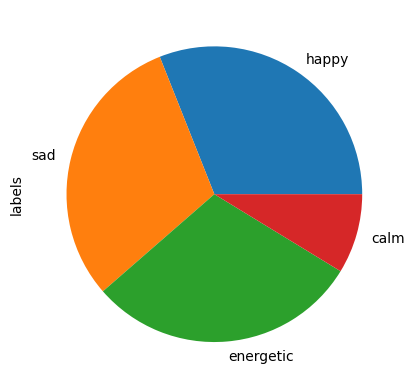

In [56]:
y_train.value_counts().plot.pie(labels=("happy", "sad", "energetic", "calm"));

- Controllo se dalla `loudness` potrebbero esserci correlazioni più forti con `labels`

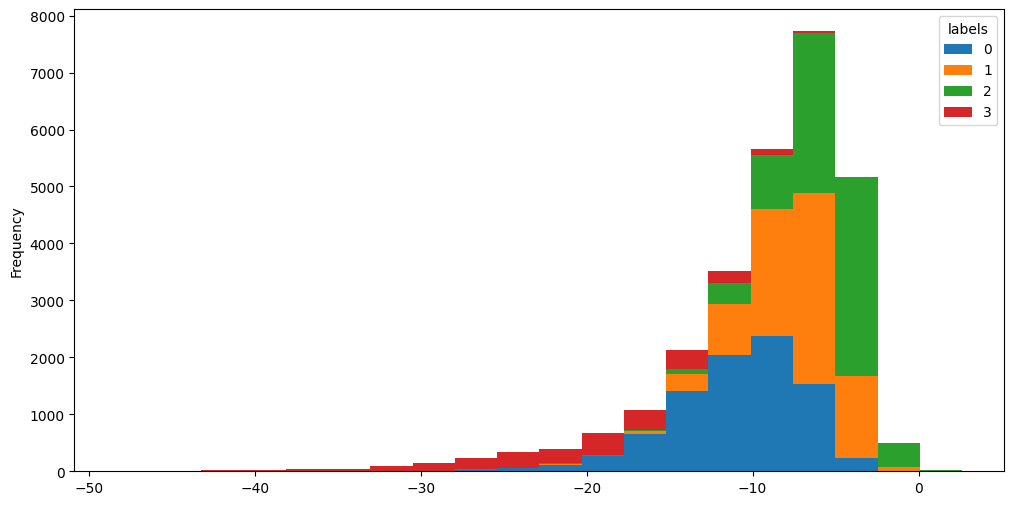

In [57]:
songs.pivot(columns="labels")["loudness"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

- Come si può notare, ad un valore di volume più basso corrispondono tendenzialmente tracce calme, mentre a valori più alti ci sono tracce principalmente felici, energetiche o tristi

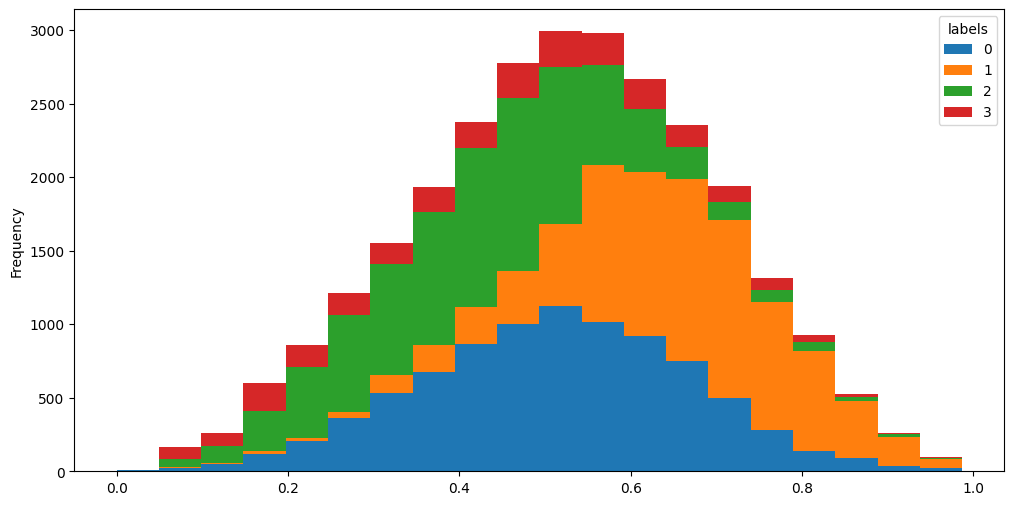

In [58]:
songs.pivot(columns="labels")["danceability"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

- Con questo grafico si può invece notare come a valori di danzabilità bassi corrispondano principalmente tracce tristi o calme, mentre a valori più alti ci sono tracce felici.

**Danzabilità**

- Controlando quante sono le tracce audio più ballabili si intuisce che molte di queste potrebbero essere tracce musicali

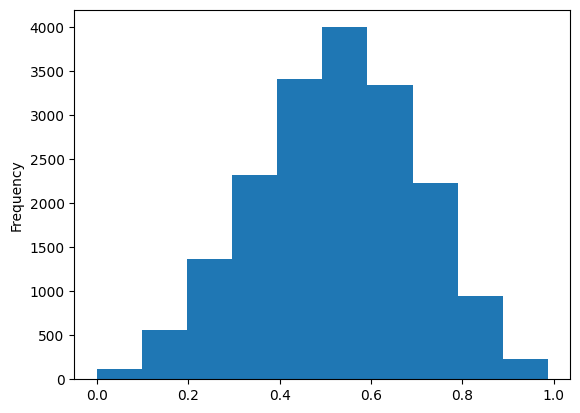

In [59]:
X_train["danceability"].plot.hist();

**Mapping**

- Creo una mappa di colori per i valori in `labels`

In [60]:
colors_map = {
    0 : "yellow",
    1 : "gray",
    2 : "red",
    3 : "green"
}

In [61]:
colors_train = y_train.map(colors_map)
colors_val = y_val.map(colors_map)

- Visualizzo un grafico a dispersione secondo la mappa dei colori appena creata, usando come asse delle x `acousticness` e come asse delle y `valence`

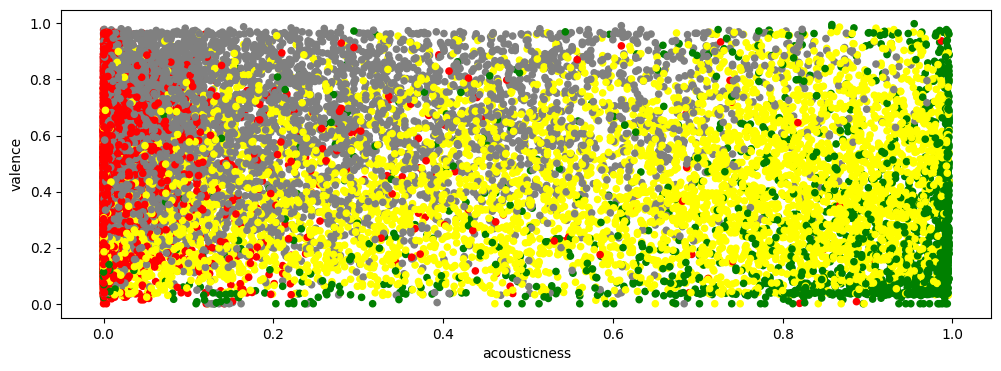

In [62]:
X_train.plot.scatter("acousticness", "valence", c=colors_train, figsize=(12,4));

## Perceptron

- Provo a fare una classificazione lineare con il `Perceptron`

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

In [64]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("perc", Perceptron(random_state=23))
])

model.fit(X_train, y_train)

model.score(X_val, y_val)

0.7368080284881838

- L'accuratezza non è altissima
- Controllo i coefficienti e le intercette

In [65]:
model.named_steps["perc"].coef_

array([[  3.02239614,   2.5346516 ,  -8.27827961,   1.76340847,
         -2.69731339,   1.1363836 ,  -8.99776011,   2.05394964,
         -0.74812701,  -2.18393986,   1.00307384],
       [ -3.83834694,   5.9312725 ,   1.04536186,   2.67885729,
          2.84806479,   0.24316323,   1.28219968,   0.75160196,
          4.26691941,  -0.84763553,   0.47684099],
       [ -1.89871547,  -2.04698802,   8.37408774,   0.52331869,
          2.57817208, -12.80893441,  -0.7659761 ,  -1.3371413 ,
         -2.4720859 ,   4.96998648,  -1.60538972],
       [ -0.58247398,  -3.02914181,  -9.51160643,  -8.62947591,
          4.51779502,   1.99127523,  28.28043147,   1.95112071,
         -3.81526247,   5.82188524,  -2.27221391]])

In [66]:
model.named_steps["perc"].intercept_

array([ -7.,  -6., -17., -66.])

- Si può notare come siano stati creati 4 iperpiani per dividere le 4 classi

**Matrice di confusione**

In [67]:
from sklearn.metrics import confusion_matrix

In [68]:
y_pred = model.predict(X_val)
matrix = confusion_matrix(y_val, y_pred)

In [69]:
pd.DataFrame(matrix, index=model.classes_, columns=model.classes_)

,0,1,2,3
0,2164,396,242,156
1,665,1800,282,29
2,109,453,2074,29
3,10,64,4,790


- Ad occhio si nota che le tracce calme sono state indovinate con meno errori rispetto alle altre

**Precisione, recall e f1**

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [71]:
precision_score(y_val, y_pred, average=None)

array([0.73405699, 0.66347217, 0.79707917, 0.78685259])

- La precisione per le tracce `felici` è molto bassa rispetto a quella delle tracce `calme` o `energetiche`

In [72]:
recall_score(y_val, y_pred, average=None)

array([0.73157539, 0.64841499, 0.7782364 , 0.91013825])

- In questo caso si nota che le tracce `calme` hanno anche una recall molto alta, mentre le tracce `felici` ne hanno una molto bassa

In [74]:
f1_score(y_val, y_pred, average=None)

array([0.73281409, 0.65585717, 0.78754509, 0.84401709])

- Come prima, le tracce `calme` hanno un risultato più alto

In [75]:
f1_score(y_val, y_pred, average="macro")

0.7550583605879679

## Alberi decisionali

In [76]:
from sklearn.tree import DecisionTreeClassifier

- Ora provo ad utilizzare un `classificatore ad albero decisionale`
    - Il parametro `max_depth` serve per evitare un possibile overfitting

In [77]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("tree", DecisionTreeClassifier(max_depth=6))
])

model.fit(X_train, y_train)

model.score(X_val, y_val)

0.8360850329124851

- Il modello è più accurato di quello precedente, e aumentando il `max_depth` potrebbe migliorare ancora il risultato

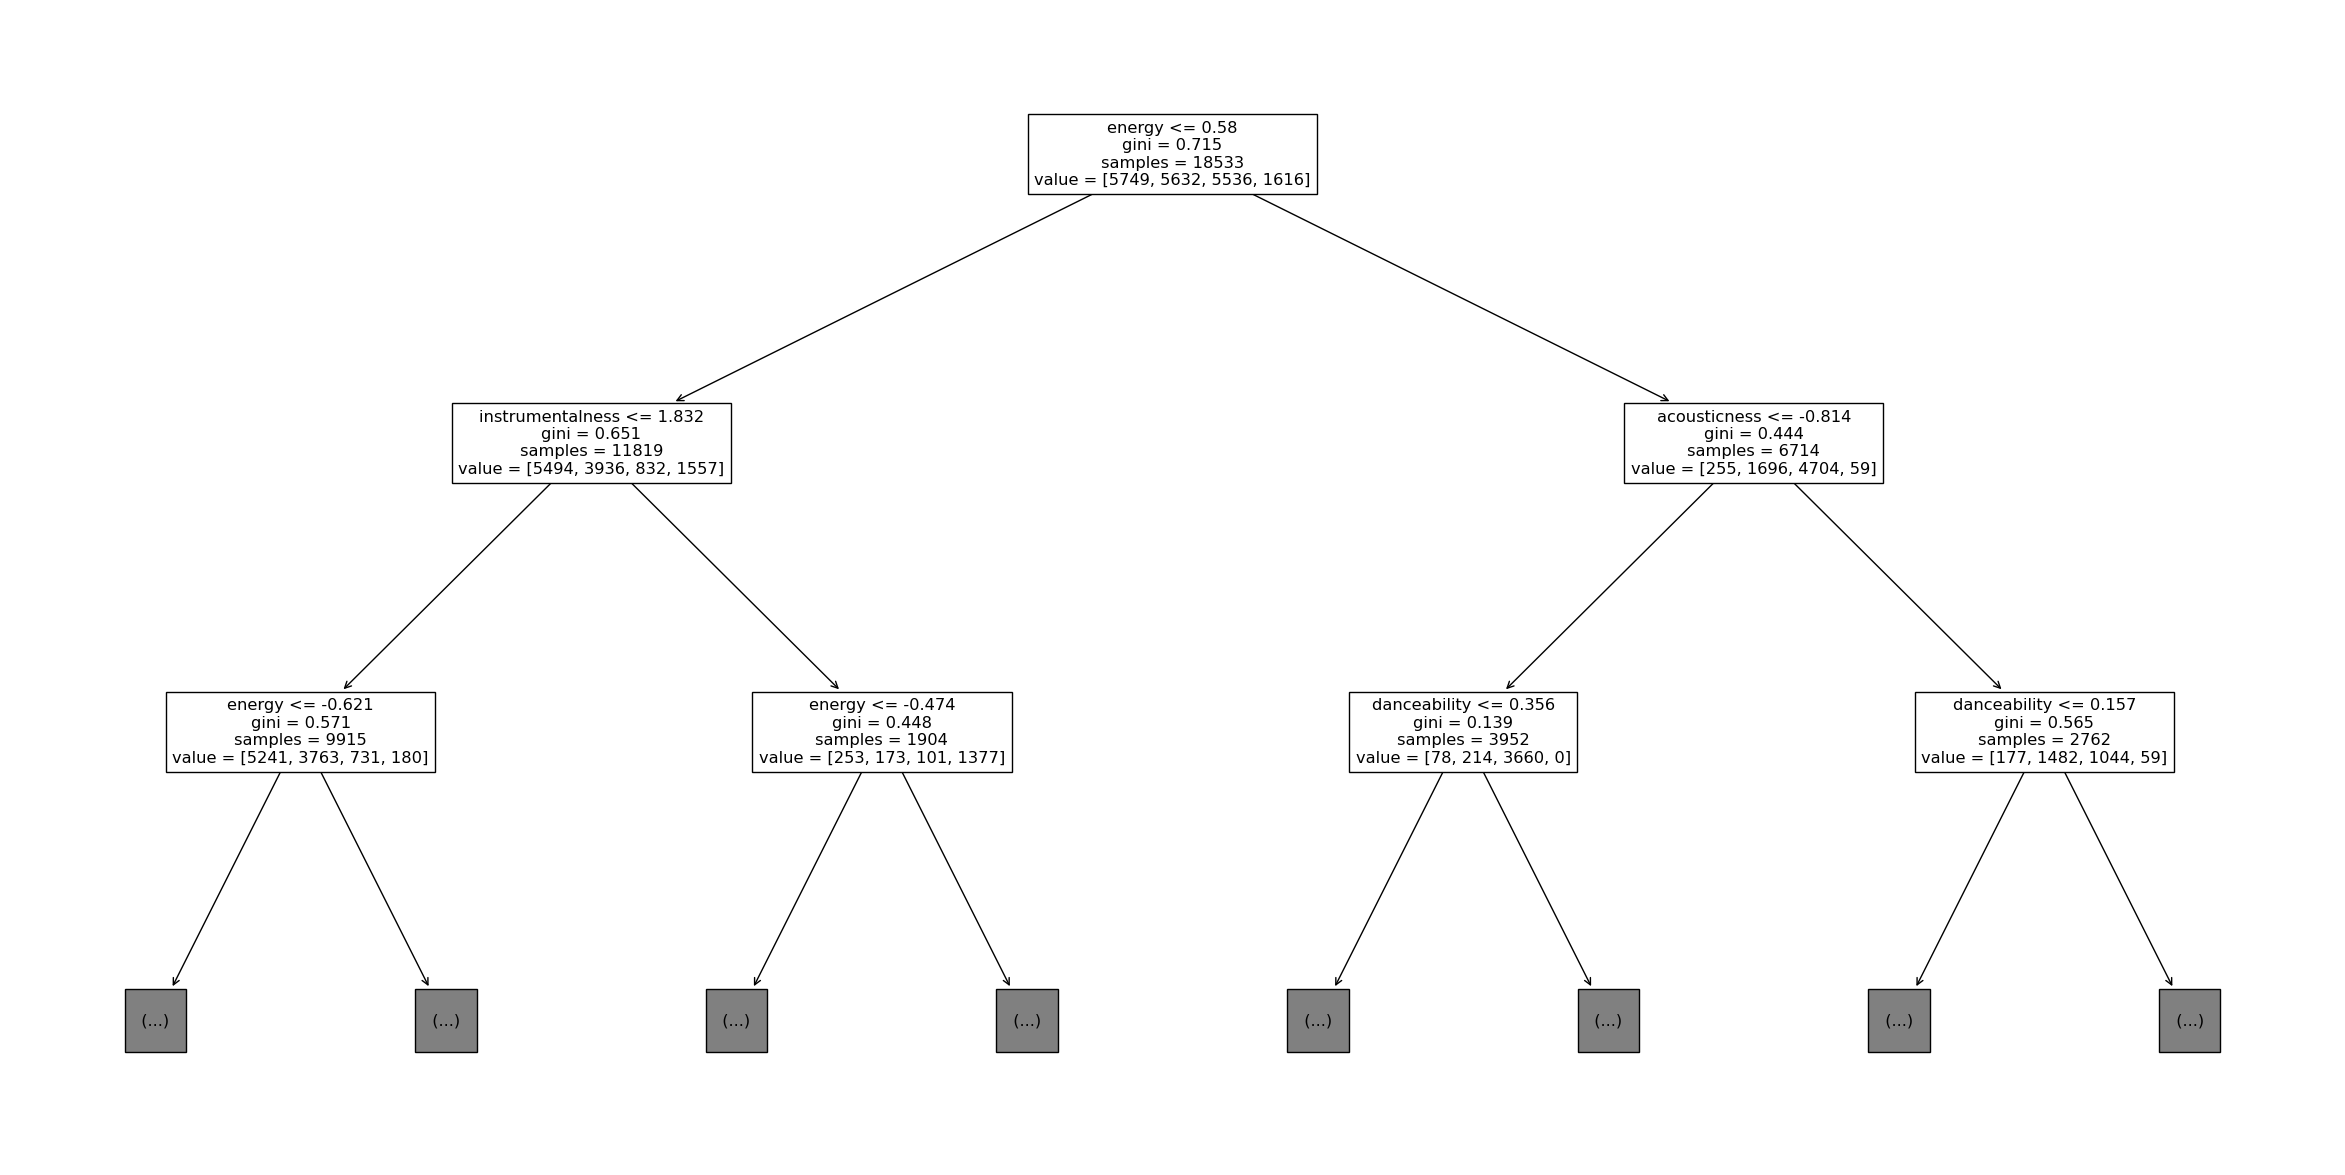

In [78]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(model.named_steps["tree"], feature_names=X_train.columns.to_list(), max_depth=2);

- Si può notare che come prima variabile usata dal modello per fare la classificazione viene utilizzata `energy`, per poi comparire di nuovo più volte, così come `danceability`

In [79]:
from sklearn.tree import export_text
print(export_text(model.named_steps["tree"], feature_names=X_train.columns.to_list(), max_depth=3))

|--- energy <= 0.58
|   |--- instrumentalness <= 1.83
|   |   |--- energy <= -0.62
|   |   |   |--- acousticness <= -0.04
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- acousticness >  -0.04
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- energy >  -0.62
|   |   |   |--- instrumentalness <= -0.61
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- instrumentalness >  -0.61
|   |   |   |   |--- truncated branch of depth 3
|   |--- instrumentalness >  1.83
|   |   |--- energy <= -0.47
|   |   |   |--- spec_rate <= -0.43
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- spec_rate >  -0.43
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- energy >  -0.47
|   |   |   |--- spec_rate <= -0.36
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- spec_rate >  -0.36
|   |   |   |   |--- truncated branch of depth 3
|--- energy >  0.58
|   |--- acousticness <= -0.81
|   |   |--- danceability <= 0.36
|   |   |  

- Attraverso la funzione `export_text` di sklearn.tree è possibile vedere con più facilità anche fino a 3 nodi di profondità
- Qui si nota che anche `instrumentalness` e `acousticness` compaiano più volte
- E' quindi possibile che `energy`, `acousticness`, `danceability` e `instrumentalness` siano le variabili più significative
- Faccio una prova

In [32]:
significants = ["acousticness","danceability", "instrumentalness", "energy"]

In [80]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("tree", DecisionTreeClassifier(max_depth=6))
])

model.fit(X_train[significants], y_train)

model.score(X_val[significants], y_val)

0.8193590158627387

L'accuratezza è di poco più bassa rispetto ad utilizzare 11 variabili, e ne ho utilizzate solo 4 (con valori diversi di `max_depth` il risultato potrebbe cambiare, persino peggiorare)

## Xgboost

- Usando la libreria XGBoost l'accuratezza aumenta significativamente, anche con un albero basso (senza `max_depth`=2, prende di default `max_depth`=6)

In [81]:
from xgboost import XGBClassifier

In [82]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("xbc", XGBClassifier(max_depth=2))
])

model.fit(X_train, y_train)

model.score(X_val, y_val)

0.9275925326427107

- Il modello è molto più accurato anche se impiega più tempo del precedente

## Cross Validation e Grid Search

- Con una `Cross Validation` e `Grid Search` ora provo a ottenere un risultato migliore per tutti e tre i modelli

**Perceptron**

In [83]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [84]:
skf = StratifiedKFold(5, shuffle=True, random_state=23)

In [85]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("perc", Perceptron(random_state=23))
])

grid = [
    {
        "perc__penalty" : ["elasticnet"],
        "perc__l1_ratio" : [0.2, 0.5],
        "perc__alpha" : np.logspace(-2, 1, 4)
    },
    {
        "perc__penalty" : ["l1", "l2"],
        "perc__alpha" : np.logspace(-2, 1, 4)
    },
    {
        "perc__penalty" : ["none"]
    }
]

gs = GridSearchCV(model, grid, cv=skf)

- Ho costruito una griglia che permette di esplorare il mio modello `perceptron` dentro la `pipeline` attraverso le regolarizzazione `elasticnet`, `l1`, `l2` o nessuna (quella base).
- Inoltre, per ogni regolarizzazione, vengono provati 4 valori di `alpha` da 10^-2 a 10
- Per la regolarizzazione `elasticnet` sono provati anche 2 valori di `l1_ratio`

In [86]:
X = songs.drop(columns=["labels"], axis=1) 
y = songs["labels"]

- Dopo aver preso tutti i dati dal dataset (divisi per feature e target), eseguo l'addestramento del modello

In [87]:
gs.fit(X, y);

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 85.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sk

- Visualizzo i primi 5 risultati della Grid Search

In [88]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_perc__alpha,param_perc__l1_ratio,param_perc__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.153269,0.021654,0.002851,0.000702,0.01,0.5,elasticnet,"{'perc__alpha': 0.01, 'perc__l1_ratio': 0.5, '...",0.779856,0.725180,0.752158,0.775540,0.674460,0.741439,0.038740,1
8,0.125939,0.011621,0.003914,0.001697,0.01,NaN,l1,"{'perc__alpha': 0.01, 'perc__penalty': 'l1'}",0.709353,0.731295,0.613849,0.680576,0.764928,0.700000,0.051150,2
0,0.197875,0.069404,0.003344,0.001027,0.01,0.2,elasticnet,"{'perc__alpha': 0.01, 'perc__l1_ratio': 0.2, '...",0.589568,0.699101,0.706115,0.746583,0.668705,0.682014,0.052470,3
3,0.140245,0.014613,0.003493,0.000820,0.1,0.5,elasticnet,"{'perc__alpha': 0.1, 'perc__l1_ratio': 0.5, 'p...",0.696043,0.668525,0.700000,0.531295,0.595863,0.638345,0.065277,4
9,0.132903,0.041354,0.005140,0.001161,0.01,NaN,l2,"{'perc__alpha': 0.01, 'perc__penalty': 'l2'}",0.661871,0.676259,0.640647,0.566367,0.612230,0.631475,0.039046,5


- In questo caso l'accuratezza è peggiorata
- Controllo l'`f1_score`, il `precision_score` e il `recall_score`

In [89]:
y_pred = gs.predict(X)
f1_score(y, y_pred, average="macro")

0.6635114089994428

In [90]:
f1_score(y, y_pred, average=None)

array([0.74487647, 0.74176588, 0.82900986, 0.33839342])

- Principalmente per l'`f1_score` le tracce `calme` contribuiscono enormemente a diminuirne il valore, mentre le tracce `energetiche` ad aumentarlo

In [91]:
precision_score(y, y_pred, average=None)

array([0.67375952, 0.75402384, 0.82800146, 0.78908555])

- Principalmente per il `precision_score` le tracce `felici` contribuiscono ad aumentarne il valore, mentre le tracce `tristi` a diminuirlo

In [92]:
recall_score(y, y_pred, average=None)

array([0.83277822, 0.7299001 , 0.83002073, 0.21537842])

- Principalmente per il `recall_score` le tracce `tristi` ed `energetiche` contribuiscono ad aumentarne il valore, mentre le tracce `calme` a diminuirlo

**Decision Tree**

In [93]:
model = Pipeline([
    ("scale", None),
    ("tree", DecisionTreeClassifier())
])

grid = [
    {
        "scale" : [None, StandardScaler()],
        "tree__max_depth" : range(3, 8),
    },
    {
        "scale" : [None, StandardScaler()],
        "tree__max_depth" : [None],
    }
]

gs = GridSearchCV(model, grid, cv=skf)

- Effettuo ora una `Grid Search` con il `Decision Tree Classifier`, con lo stesso `Stratified Kross Folder` di prima.
- Provo profondità massima nulla e da 3 ad 7, sia con standardizzazione dei dati che senza

In [94]:
gs.fit(X, y);

- Stampo i risultati migliori

In [95]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale,param_tree__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.343198,0.030232,0.004509,0.000987,StandardScaler(),None,"{'scale': StandardScaler(), 'tree__max_depth':...",0.872482,0.866007,0.871403,0.871223,0.873561,0.870935,0.002603,1
10,0.317150,0.012038,0.003033,0.001035,None,None,"{'scale': None, 'tree__max_depth': None}",0.864748,0.863849,0.867446,0.865647,0.862410,0.864820,0.001693,2
9,0.210172,0.010799,0.003740,0.000639,StandardScaler(),7,"{'scale': StandardScaler(), 'tree__max_depth': 7}",0.866547,0.859173,0.853957,0.862770,0.854676,0.859424,0.004784,3
4,0.190246,0.008763,0.002325,0.000402,None,7,"{'scale': None, 'tree__max_depth': 7}",0.854496,0.853058,0.837770,0.849640,0.844784,0.847950,0.006090,4
8,0.183278,0.026338,0.002833,0.000529,StandardScaler(),6,"{'scale': StandardScaler(), 'tree__max_depth': 6}",0.851619,0.848921,0.845863,0.839928,0.837230,0.844712,0.005396,5


- Come era prevedibile, senza un'altezza massima si ha l'accuratezza più alta, e al diminuire dell'altezza massima si ha un'accuratezza minore

**XGBClassifier**

In [96]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("xbc", XGBClassifier())
])

grid = {
    "xbc__max_depth" : range(2, 7),
}

gs = GridSearchCV(model, grid, cv=skf)

- In modo analogo al `Decision Tree Classifier` provo l'`XGBClassifier` con però altezza massima da 2 a 6

In [97]:
gs.fit(X, y);

- Essendo già di suo lento come modello `XGBClassifier`, in questo caso ci impiega molto tempo per completare il fit
- Ora visualizzo i 5 migliori risultati

In [98]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xbc__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,8.433210,0.212812,0.057248,0.003076,5,{'xbc__max_depth': 5},0.944604,0.949460,0.943525,0.950360,0.945863,0.946763,0.002689,1
2,6.688358,0.057155,0.055313,0.012422,4,{'xbc__max_depth': 4},0.945324,0.949281,0.944784,0.948201,0.944065,0.946331,0.002037,2
4,9.961489,0.064461,0.084301,0.014683,6,{'xbc__max_depth': 6},0.943885,0.948921,0.945863,0.947122,0.945683,0.946295,0.001670,3
1,5.040798,0.057920,0.040584,0.008568,3,{'xbc__max_depth': 3},0.935612,0.941007,0.941367,0.942446,0.935791,0.939245,0.002932,4
0,3.679979,0.216705,0.035195,0.007940,2,{'xbc__max_depth': 2},0.922302,0.929137,0.929317,0.932734,0.922302,0.927158,0.004167,5


- In questo caso il modello con l'accuratezza migliore non è quello con la profontità maggiore (che è addirittura il terzo in ordine di accuratezza) ma quello con profondità pari a 5

## Conclusioni

- Concludendo, il modello più accurato è l'`XGBClassifier` di `XGBoost` con una `nested cross validation` e `profondità` 5, con un 94.67% di `accuratezza`